In [1]:
#pip install -U sentence-transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()
import cv2, warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Add, Dropout, LSTM, TimeDistributed, Embedding, RepeatVector, Concatenate, Bidirectional, Convolution2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
import os
import sys
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt 

import numpy as np
import pandas as pd
import torch


sys.path.append('../input/sentence-transformers-222/sentence-transformers')
from sentence_transformers import SentenceTransformer, models

comp_path = Path('/kaggle/input/stable-diffusion-image-to-prompts/')

In [3]:
class CFG:
    device = "cuda"
    seed = 42
    embedding_length = 384
    sentence_model_path = "/kaggle/input/sentence-transformers-222/all-MiniLM-L6-v2"
    blip_model_path = "/kaggle/input/clip-interrogator-models-x/model_large_caption.pth"
    ci_clip_model_name = "ViT-H-14/laion2b_s32b_b79k"
    clip_model_name = "ViT-H-14"
    clip_model_path = "/kaggle/input/clip-interrogator-models-x/CLIP-ViT-H-14-laion2B-s32B-b79K/open_clip_pytorch_model.bin"
    cache_path = "/kaggle/input/clip-interrogator-models-x"

In [4]:
df_submission = pd.read_csv(comp_path / 'sample_submission.csv', index_col='imgId_eId')
df_submission.head()

,val
imgId_eId,
20057f34d_0,0.018848
20057f34d_1,0.030190
20057f34d_2,0.072792
20057f34d_3,-0.000673
20057f34d_4,0.016774


# Calculating Stable Diffusion Prompt Embeddings

In [5]:
images = os.listdir(comp_path / 'images')
imgIds = [i.split('.')[0] for i in images]

eIds = list(range(CFG.embedding_length))

imgId_eId = [
    '_'.join(map(str, i)) for i in zip(
        np.repeat(imgIds, CFG.embedding_length),
        np.tile(range(CFG.embedding_length), len(imgIds))
    )
]

assert sorted(imgId_eId) == sorted(df_submission.index)

In [6]:
st_model = SentenceTransformer('/kaggle/input/sentence-transformers-222/all-MiniLM-L6-v2')

In [7]:
prompts = pd.read_csv(comp_path / 'prompts.csv', index_col='imgId')
prompts.head(7)

,prompt
imgId,
20057f34d,hyper realistic photo of very friendly and dys...
227ef0887,"ramen carved out of fractal rose ebony, in the..."
92e911621,ultrasaurus holding a black bean taco in the w...
a4e1c55a9,a thundering retro robot crane inks on parchme...
c98f79f71,"portrait painting of a shimmering greek hero, ..."
d8edf2e40,an astronaut standing on a engaging white rose...
f27825b2c,Kaggle employee Phil at a donut shop ordering ...


In [8]:
prompt_embeddings = st_model.encode(prompts['prompt']).flatten()

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()
import cv2, warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Add, Dropout, LSTM, TimeDistributed, Embedding, RepeatVector, Concatenate, Bidirectional, Convolution2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:
final_model = tf.keras.models.load_model("/kaggle/input/imagetoprompt-modelfile/image_caption_generator.h5")

In [11]:
img_path = '/kaggle/input/flickr8k/Images'
images = glob(img_path+'/*.jpg')
images[:5]

['/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg',
 '/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg',
 '/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg',
 '/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg',
 '/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg']

In [12]:
len(images)

8091

In [13]:
captions = open('/kaggle/input/flickr8k/captions.txt','rb').read().decode('utf-8').split('\n')
captions[:5]

['image,caption',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .']

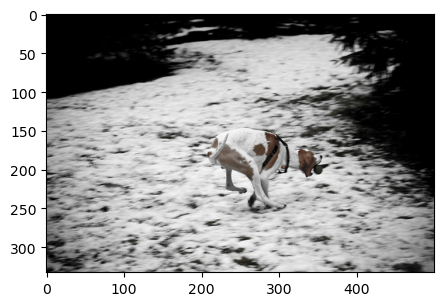

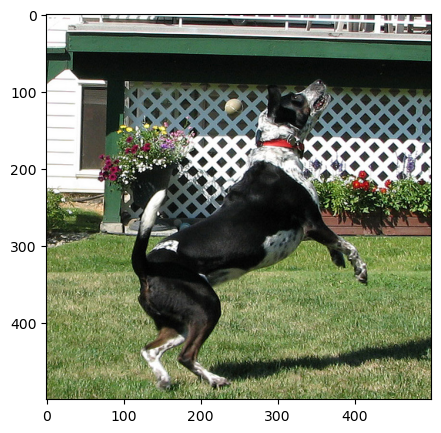

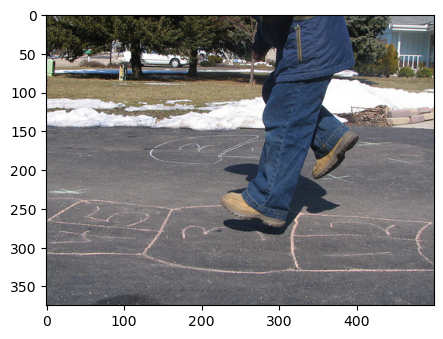

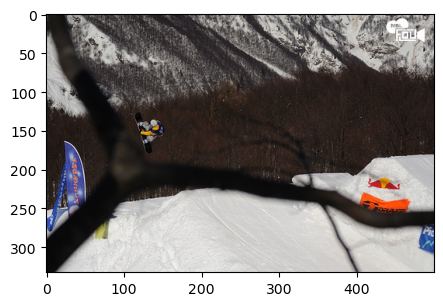

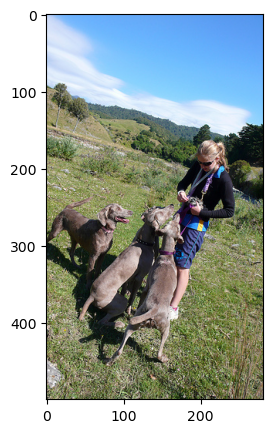

In [14]:
for i in range(5):
    plt.figure(figsize=(5,5))
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img);

In [15]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense

resnet_weights_path = '/kaggle/input/d/alexisbcook/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels.h5'


In [16]:
#inception_model = ResNet50(include_top=True)
inception_model = ResNet50(include_top = True, pooling = 'avg', weights = resnet_weights_path)
inception_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [17]:
last = inception_model.layers[-2].output # Output of the penultimate layer of ResNet model
model_1 = Model(inputs=inception_model.input,outputs=last)
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [18]:
img_features = {}
count = 0

for img_path in tqdm(images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(224,224)) # ResNet model requires images of dimensions (224,224,3)
    img = img.reshape(1,224,224,3) # Reshaping image to the dimensions of a single image
    features = model_1.predict(img).reshape(2048,) # Feature extraction from images
    img_name = img_path.split('/')[-1] # Extracting image name
    img_features[img_name] = features
    count += 1
    # Fetching the features of only 1500 images as using more than 1500 images leads to overloading memory issues
    if count == 500:
        break
    if count % 50 == 0:
        print(count)

  0%|          | 0/8091 [00:00<?, ?it/s]

1/1 [==============================] - 0s 116ms/step
50
1/1 [==============================] - 0s 107ms/step
100
1/1 [==============================] - 0s 100ms/step
150
1/1 [==============================] - 0s 110ms/step
200
1/1 [==============================] - 0s 108ms/step
250
1/1 [==============================] - 0s 97ms/step
300
1/1 [==============================] - 0s 109ms/step
350
1/1 [==============================] - 0s 124ms/step
400
1/1 [==============================] - 0s 126ms/step
450
1/1 [==============================] - 0s 120ms/step


In [19]:
len(img_features)

500

In [20]:
captions = captions[1:]
captions[:5]

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .']

In [21]:
captions[8].split(',')[1]

'Two dogs of different breeds looking at each other on the road .'

In [22]:
captions_dict = {}

for cap in captions:
    try:
        img_name = cap.split(',')[0]
        caption = cap.split(',')[1]
        # Each image has 5 captions
        if img_name in img_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption] # Storing the first caption
            else:
                captions_dict[img_name].append(caption) # Adding the remaining captions
    except:
        break

In [23]:
len(captions_dict)

500

In [24]:
def text_preprocess(text):
    modified_text = text.lower() # Converting text to lowercase
    modified_text = 'startofseq ' + modified_text + ' endofseq' # Appending the special tokens at the beginning and ending of text
    return modified_text

In [25]:
# Storing the preprocessed text within the captions dictionary
for key, val in captions_dict.items():
    for item in val:
        captions_dict[key][val.index(item)] = text_preprocess(item)

In [26]:
count_words = dict()
cnt = 1

for key, val in captions_dict.items(): # Iterating through all images with keys as images and their values as 5 captions
    for item in val: # Iterating through all captions for each image
        for word in item.split(): # Iterating through all words in each caption
            if word not in count_words:
                count_words[word] = cnt
                cnt += 1

In [27]:
len(count_words)

2296

In [28]:
# Encoding the text by assigning each word to its corresponding index in the vocabulary i.e. count_words dictionary
for key, val in captions_dict.items():
    for caption in val:
        encoded = []
        for word in caption.split():
            encoded.append(count_words[word])
        captions_dict[key][val.index(caption)] = encoded

In [29]:
# Determining the maximum possible length of text within the entire captions text corpus
max_len = -1

for key, value in captions_dict.items():
    for caption in value:
        if max_len < len(caption):
            max_len = len(caption)

print(max_len)            

34


In [30]:
vocab_size = len(count_words) # Vocab size is the total number of words present in count_words dictionary
vocab_size

2296

In [31]:
inverse_dict = {val: key for key,val in count_words.items()}

In [32]:
len(count_words)

2296

In [33]:
imgs_path = '/kaggle/input/stable-diffusion-image-to-prompts/images'
images2 = glob(imgs_path+'/*.png')

In [34]:
images2[:5]


['/kaggle/input/stable-diffusion-image-to-prompts/images/f27825b2c.png',
 '/kaggle/input/stable-diffusion-image-to-prompts/images/92e911621.png',
 '/kaggle/input/stable-diffusion-image-to-prompts/images/a4e1c55a9.png',
 '/kaggle/input/stable-diffusion-image-to-prompts/images/20057f34d.png',
 '/kaggle/input/stable-diffusion-image-to-prompts/images/d8edf2e40.png']

In [35]:
def getImage(idx):
    test_img_path = idx
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(224,224))
    test_img = np.reshape(test_img,(1,224,224,3))
    return test_img

  0%|          | 0/7 [00:00<?, ?it/s]

/kaggle/input/stable-diffusion-image-to-prompts/images/f27825b2c.png
1/1 [==============================] - 0s 35ms/step
/kaggle/input/stable-diffusion-image-to-prompts/images/92e911621.png
1/1 [==============================] - 0s 32ms/step
/kaggle/input/stable-diffusion-image-to-prompts/images/a4e1c55a9.png
1/1 [==============================] - 0s 32ms/step
/kaggle/input/stable-diffusion-image-to-prompts/images/20057f34d.png
1/1 [==============================] - 0s 33ms/step
/kaggle/input/stable-diffusion-image-to-prompts/images/d8edf2e40.png
1/1 [==============================] - 0s 36ms/step
/kaggle/input/stable-diffusion-image-to-prompts/images/227ef0887.png
1/1 [==============================] - 0s 31ms/step
/kaggle/input/stable-diffusion-image-to-prompts/images/c98f79f71.png
1/1 [==============================] - 0s 31ms/step


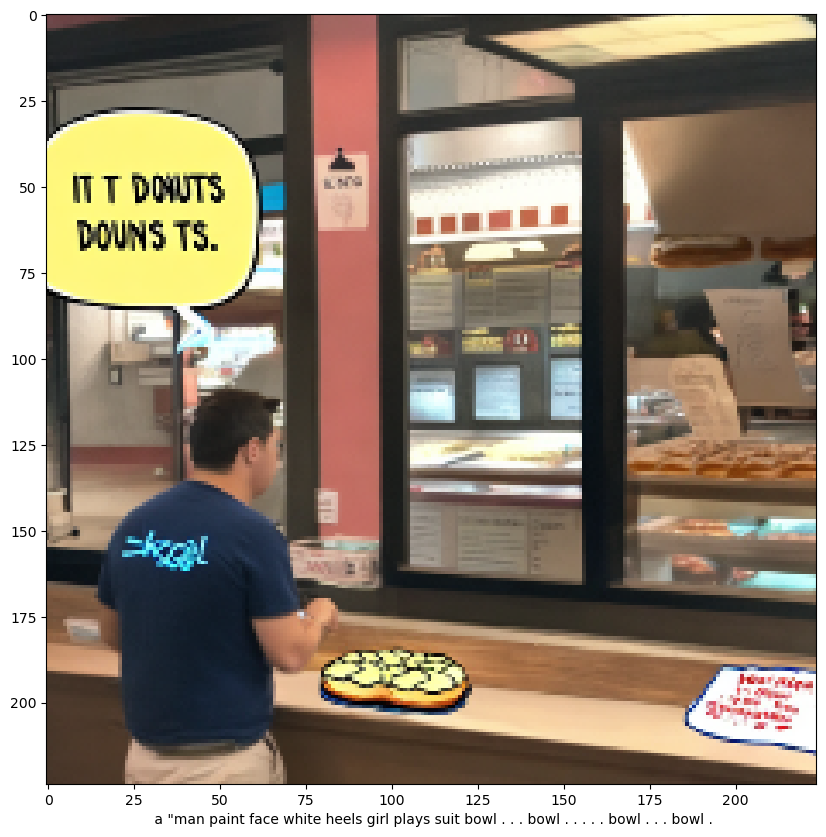

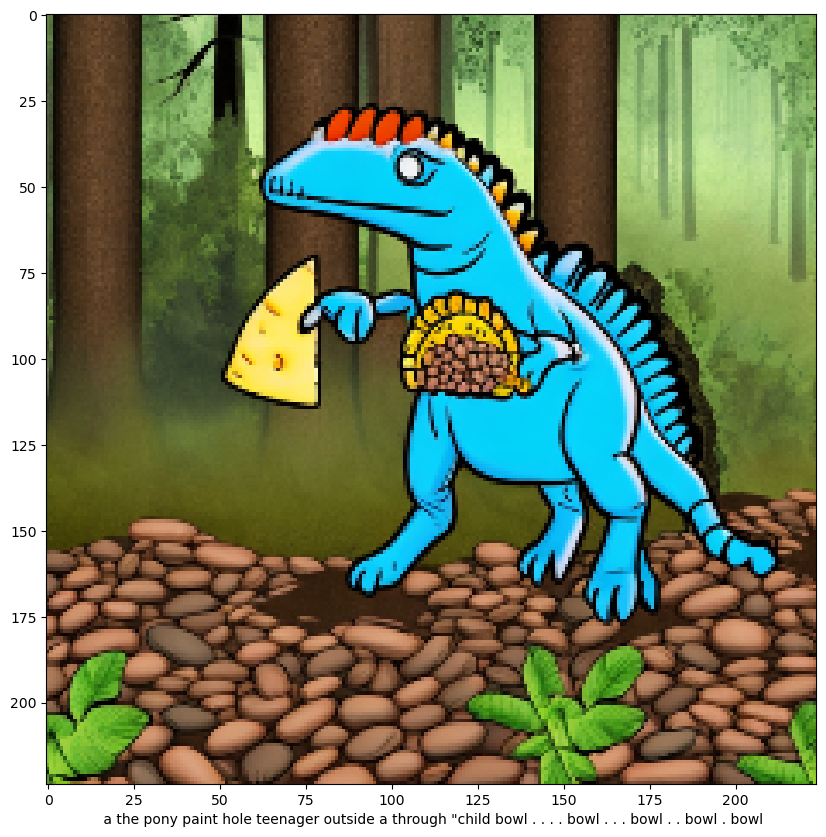

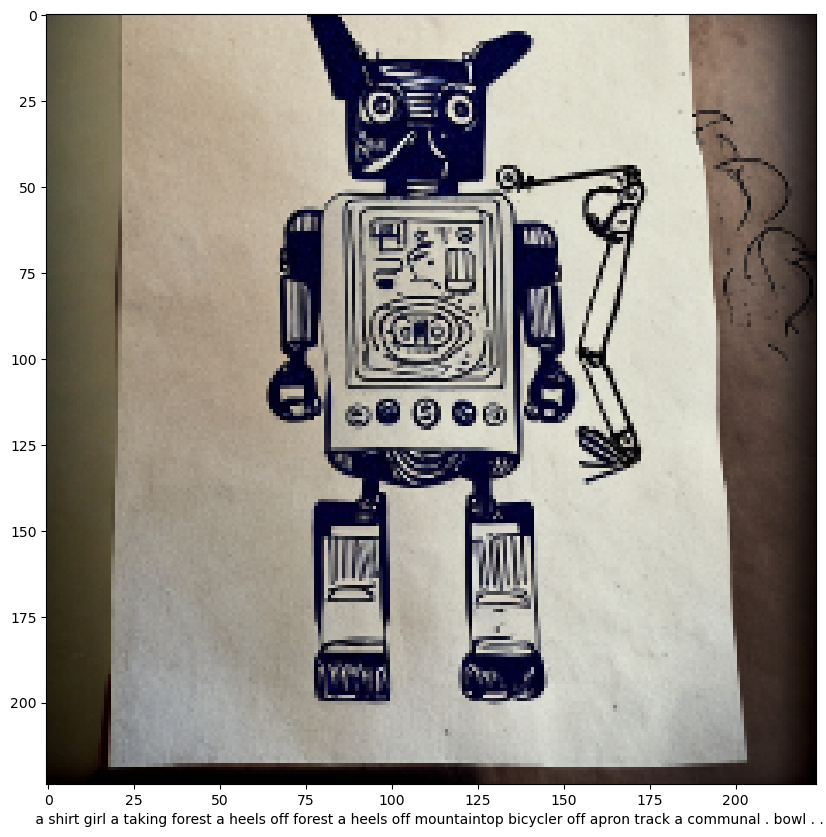

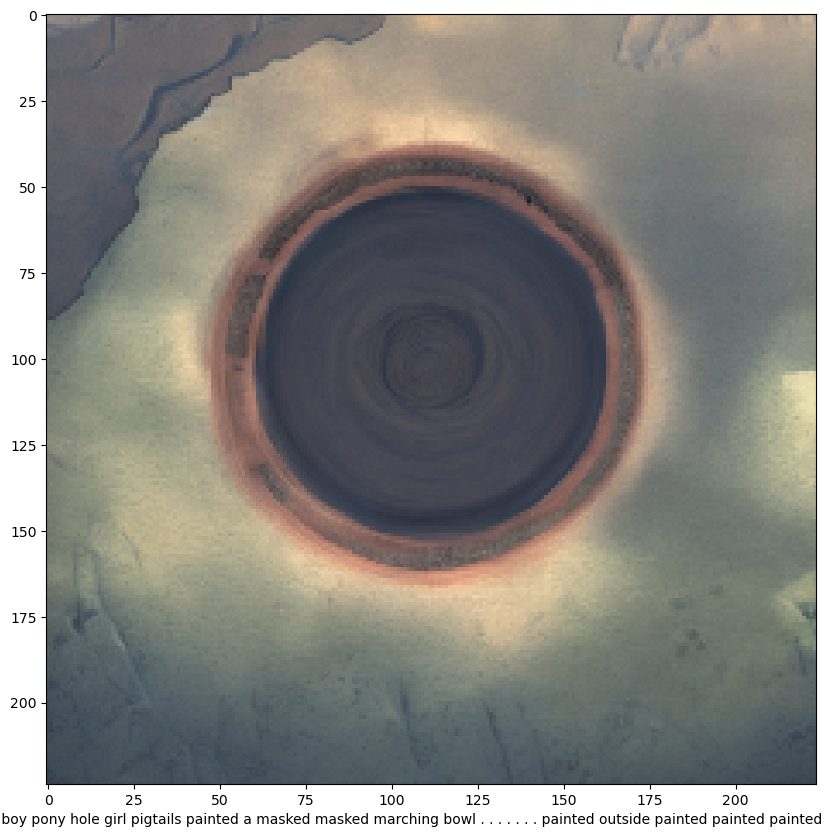

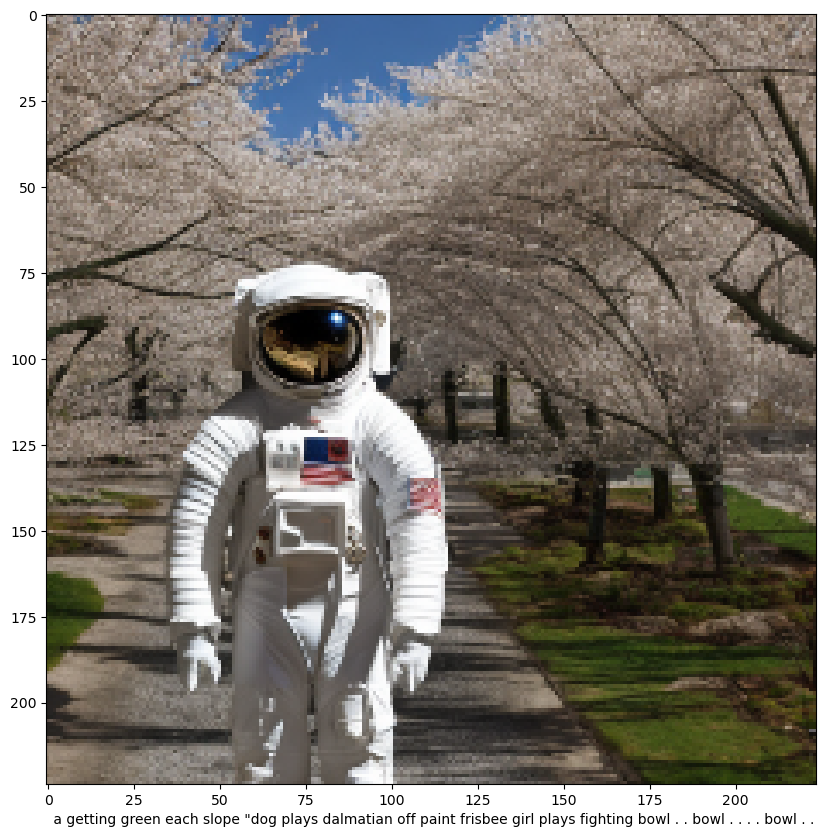

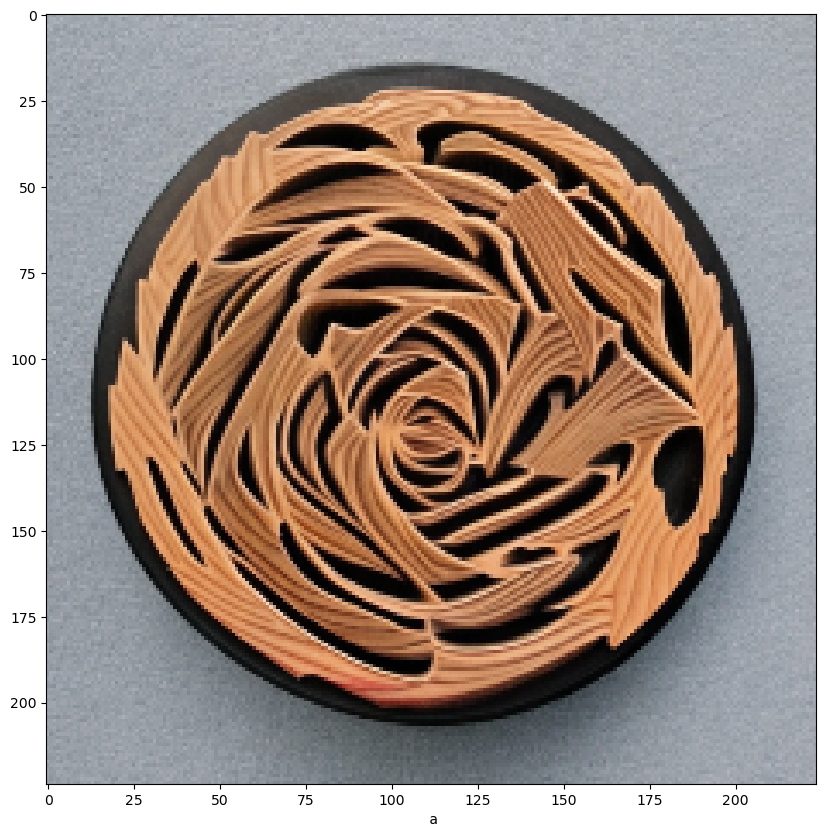

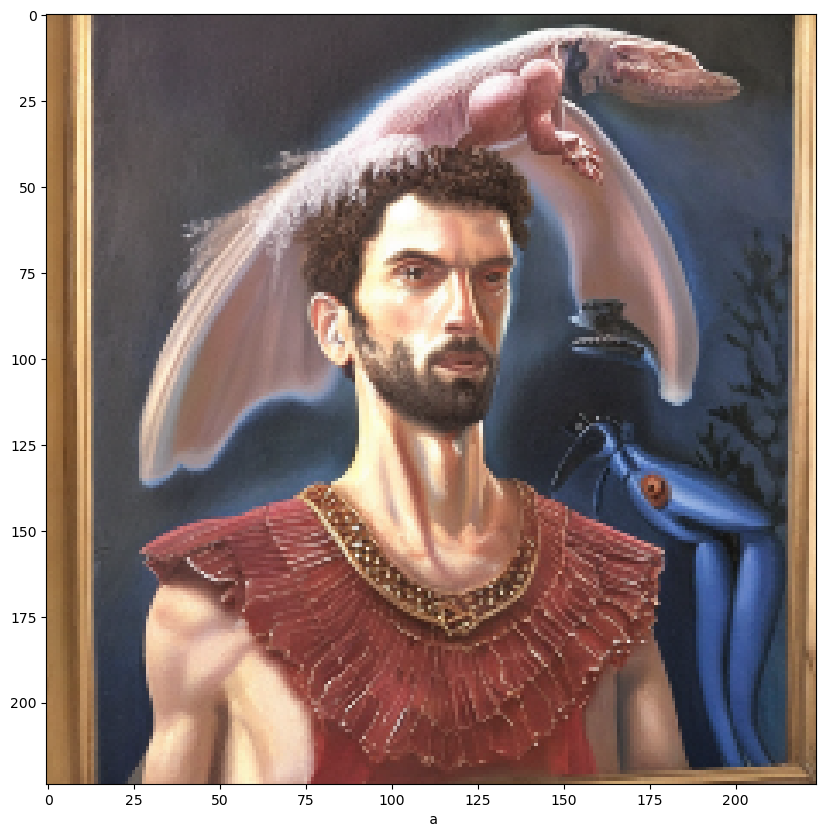

In [36]:
prompts2 = []

for img_path in tqdm(images2):
    img = cv2.imread(img_path)
    print(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(224,224)) # ResNet model requires images of dimensions (224,224,3)
    test_feature = model_1.predict(getImage(img_path)).reshape(1,2048)    
    test_img = img.reshape(224,224,3) # Reshaping image to the dimensions of a single image
    pred_text = ['startofseq']
    count = 0
    caption = '' # Stores the predicted captions text
    
    while count < 25:
        count += 1
        # Encoding the captions text with numbers
        encoded = []

        for i in pred_text:
            encoded.append(count_words[i])
        
        encoded = [encoded]
        # Padding the encoded text sequences to maximum length
        encoded = pad_sequences(encoded,maxlen=36,padding='post',truncating='post')
        pred_idx = np.argmax(final_model.predict([test_feature,encoded])) # Fetching the predicted word index having the maximum probability of occurrence
        sampled_word = inverse_dict[pred_idx] # Extracting the predicted word by its respective index
        # Checking for ending of the sequence
        if sampled_word == 'endofseq':
            break
        caption = caption + ' ' + sampled_word
        pred_text.append(sampled_word) 
        
    prompts2.append(caption)     
    
    plt.figure(figsize=(10,10))
    plt.imshow(test_img)
    plt.xlabel(caption)


In [37]:
print(prompts2)

[' a "man paint face white heels girl plays suit bowl . . . bowl . . . . . bowl . . . bowl .', ' a the pony paint hole teenager outside a through "child bowl . . . . bowl . . . bowl . . bowl . bowl', ' a shirt girl a taking forest a heels off forest a heels off mountaintop bicycler off apron track a communal . bowl . . .', ' a boy pony hole girl pigtails painted a masked masked marching bowl . . . . . . . painted outside painted painted painted outside', ' a getting green each slope "dog plays dalmatian off paint frisbee girl plays fighting bowl . . bowl . . . . bowl . .', ' a', ' a']


In [38]:
submission = pd.DataFrame(
    index=imgId_eId,
    data=prompt_embeddings,
    columns=['val']
).rename_axis('imgId_eId')

submission.to_csv('submission.csv')

In [39]:
print(prompt_embeddings)
len(prompt_embeddings)

[0.01884849 0.03018975 0.07279224 ... 0.03056301 0.01404709 0.0237637 ]


2688